In [150]:
import os

from tqdm import tqdm
import pandas as pd
import numpy as np
import cv2

import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch
import timm
import albumentations as A

In [151]:
root_path = "/home/stefan/ioai-prep/kits/neoai-2025/underfitting-cv"
seed = 42

# Data preparation

In [152]:
train = pd.read_csv(f"{root_path}/train.csv")
train["path"] = [f"{root_path}/train_images/{x}" for x in train["path"]]

train.head()

,path,class
0,/home/stefan/ioai-prep/kits/neoai-2025/underfi...,4
1,/home/stefan/ioai-prep/kits/neoai-2025/underfi...,53
2,/home/stefan/ioai-prep/kits/neoai-2025/underfi...,75
3,/home/stefan/ioai-prep/kits/neoai-2025/underfi...,43
4,/home/stefan/ioai-prep/kits/neoai-2025/underfi...,54


In [153]:
train["class"].unique()

array([ 4, 53, 75, 43, 54, 92, 56, 68, 28, 87, 85, 19,  8, 38, 12, 32, 14,
       78, 24, 13, 36, 44,  5])

In [154]:
num_classes = 102

class_weights = torch.ones(num_classes, dtype=torch.float32)
class_weights[train["class"].unique()] = 5

In [155]:
class TrainDataset(Dataset):
    def __init__(self, path, target, transform):
        self.path = path
        self.target = target
        self.transform = transform

    def __len__(self):
        return len(self.target)

    def __getitem__(self, item):

        image = cv2.imread(self.path[item])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        target = self.target[item]
        image = self.transform(image=image)["image"]
        image = image.astype(np.float32) / 255.0
        image = image - 0.5
        image = torch.from_numpy(image).permute(2, 0, 1)

        return image, target


class PetNet(nn.Module):
    def __init__(self, model_name, num_classes):
        super().__init__()
        self.model = timm.create_model(model_name, num_classes=num_classes)

    def forward(self, image):
        x = self.model(image)
        return x


def get_train_transforms(dim=224):
    return A.Compose([
        A.LongestMaxSize(max_size=dim, p=1.0),
        A.PadIfNeeded(dim, dim, p=1.0),
        
        A.HorizontalFlip(p=0.5),
        A.GaussianBlur(blur_limit=(3, 7), p=0.2),
        A.RandomBrightnessContrast(p=0.2),
    ])


def get_valid_transforms(dim=224):
    return A.Compose([
        A.LongestMaxSize(max_size=dim, p=1.0),
        A.PadIfNeeded(dim, dim, p=1.0),
    ])

In [156]:
def seed_everything(seed):
    # random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [157]:
seed_everything(230)

batch_size = 64
params_train = {
    "batch_size": batch_size,
    "shuffle": True,
    "drop_last": False,
}
device = "cuda"
dim = 224

train_dataset = TrainDataset(train["path"].tolist(), train["class"].tolist(), get_train_transforms(dim))
train_loader = DataLoader(
    train_dataset,
    **params_train,
)

# Model selection

In [158]:
def load_model():
    model = PetNet("tiny_vit_5m_224.dist_in22k_ft_in1k", num_classes=num_classes)

    model_dict = torch.load(
        f"{root_path}/model.pt",
        map_location="cuda",
        weights_only=False,
    )
    model.load_state_dict(model_dict, strict=False)

    model = model.to(device)
    return model

model = load_model()
model

PetNet(
  (model): TinyVit(
    (patch_embed): PatchEmbed(
      (conv1): ConvNorm(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (act): GELU(approximate='none')
      (conv2): ConvNorm(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (stages): Sequential(
      (0): ConvLayer(
        (blocks): Sequential(
          (0): MBConv(
            (conv1): ConvNorm(
              (conv): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (act1): GELU(approximate='none')
            (conv2): ConvNorm(
              (conv): Conv2d(256, 256, kernel_si

In [159]:
model.train()

print("model ready")

model ready


In [160]:
teacher_model = load_model()
teacher_model.eval()

criterion = nn.CrossEntropyLoss(label_smoothing=0.0, weight=class_weights.to(device))

def get_loss(inputs, labels, alpha=0.7, temperature=4.0):
    logits_student = model(inputs)
    loss_student = criterion(logits_student, labels)
    
    with torch.no_grad():
        logits_teacher = teacher_model(inputs)

    student_log_prob = F.log_softmax(logits_student / temperature, dim=1)
    teacher_prob = F.softmax(logits_teacher / temperature, dim=1)

    loss_kd = F.kl_div(
        student_log_prob,
        teacher_prob,
        reduction="batchmean"
    ) * (temperature ** 2)

    loss = alpha * loss_student + (1.0 - alpha) * loss_kd
    return loss

In [161]:
scaler = torch.amp.GradScaler("cuda")
clip_grad_norm = 1

def train_model(epochs: int, lr: float):
    optimizer = AdamW(model.parameters(), lr)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs*len(train_loader), eta_min=1e-6)
    lrs = []

    for epoch in range(epochs):
        len_dataloader = len(train_loader)
        average_loss = 0

        tk0 = tqdm(enumerate(train_loader), total=len_dataloader)
        for batch_number, (inputs, labels) in tk0:
            optimizer.zero_grad()
            inputs = inputs.cuda()
            labels = labels.cuda().long()

            # 1. forward pass
            with torch.amp.autocast("cuda"):
                loss = get_loss(inputs, labels)

            # 2. backward pass
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)

            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)

            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            # 3. stats
            average_loss += loss.cpu().item()
            tk0.set_postfix(
                loss=average_loss / (batch_number + 1), epoch=epoch
            )

        lrs.append(average_loss / len_dataloader)

    return lrs

def eval_model():
    for (inputs, labels) in train_loader:
        inputs = inputs.cuda()
        labels = labels.cuda().long()

        with torch.amp.autocast("cuda"):
            logits_student = model(inputs)
            loss_ce = criterion(logits_student, labels)
            loss_ce = criterion(logits_student, labels)

        print(f"{loss_ce.item()}")
        break

In [162]:
eval_model()

4.190338134765625


In [163]:
print("fine-tuning the full model:")
lrs = train_model(100, 5e-5)

fine-tuning the full model:


  0%|          | 0/4 [00:00<?, ?it/s]/home/stefan/.local/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:182: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
100%|██████████| 4/4 [00:01<00:00,  3.67it/s, epoch=99, loss=0.756]


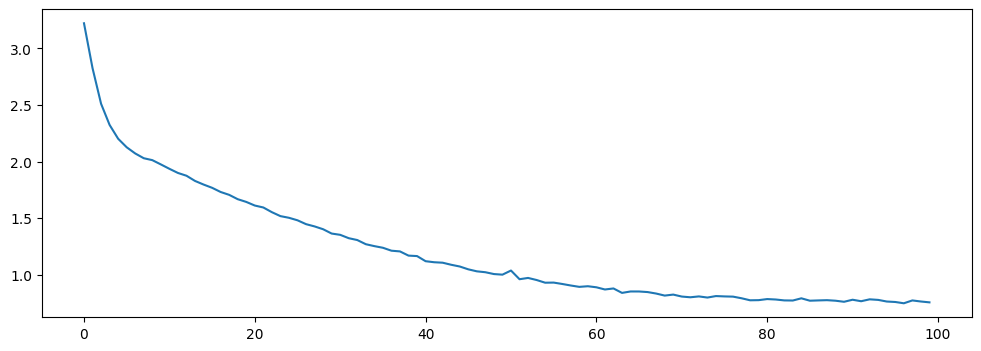

In [164]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.plot(lrs)

In [165]:
eval_model()

1.0210952758789062


# Submission

In [166]:
paths_list = []
main_path = f"{root_path}/test_images"
for path in sorted(os.listdir(main_path)):
    paths_list += [f"{main_path}/{path}"]

test = pd.DataFrame()
test["path"] = paths_list
test["class"] = 0

params_valid = {
    "batch_size": batch_size,
    "shuffle": False,
    "drop_last": False,
}

valid_loader = DataLoader(
    TrainDataset(
        test["path"].tolist(), test["class"].tolist(), get_valid_transforms(dim)
    ),
    **params_valid,
)

In [167]:
def make_predict(
    state_dict,
    valid_loader,
    name_csv="submission_1.csv",
    test_ids=[x.split("/")[-1] for x in test["path"]],
):
    preds = []
    len_loader = len(valid_loader)
    tk0 = tqdm(enumerate(valid_loader), total=len_loader)
    average_loss = 0
    model = timm.create_model("tiny_vit_5m_224.dist_in22k_ft_in1k", num_classes=102)
    model.cuda().eval()
    model.load_state_dict(state_dict)

    with torch.no_grad():
        for batch_number, (inputs, labels) in tk0:
            inputs = inputs.cuda()
            labels = labels.cuda().long()

            with torch.amp.autocast("cuda"):
                y_preds = model(inputs)

            preds += [y_preds.to("cpu").numpy()]

    preds = np.concatenate(preds)

    model.train()

    submission = pd.DataFrame()
    submission["id"] = test_ids
    submission["class"] = np.argmax(preds, 1)
    submission.to_csv(name_csv, index=None)

In [168]:
make_predict(model.model.state_dict(), valid_loader)

100%|██████████| 80/80 [00:11<00:00,  6.98it/s]
